# Overlapped Area Chart with Zoom Outsets

In this tutorial, we will be composing a four-panel plot for multiscale visualization of rainfall time series data in Texas made available by [Evett et al. via the USDA](https://doi.org/10.15482/USDA.ADC/1528713).
Our data comprises recordings from a pair of rain gauges positioned in opposite corners of the study area.

We'll need to tackle two key challenges into visualizing this rainfall time series: *1)* dealing with scrunched time/rainfall scales and *2)* co-visualizing dueling readings from our twin gauges.

### Challenge 1

To address the first challenge, we will use `matplotlib`'s `stackplot` to create area plots with a transparency ("alpha") effect.
(For those unfamiliar, area plots are line plots with the area between the line and the x-axis filled in.)
Because the gauges mostly agree, the majority of plotted area will be overlap from both gauges.
However, where they differ one area plot will show through.

### Challenge 2

The second challenge in visualizing this data arises because, in the particular study area, large amounts of rain falls in short spurts.
So, when we zoom out to see the whole month and the maximum rainfall rate, large spikes in the data cause the rest of the data to be scrunched into obscurity.

To plot our data without losing information about low-magnitude rainfall and the short-time events, we will use the `outset` package draw supplementary views of the data at alternate magnifications.
These auxiliary plots will be combined with the main plot (overall view) as an axes grid.

### Visualization Result

Here's a sneak peek at the visualization we'll be building!

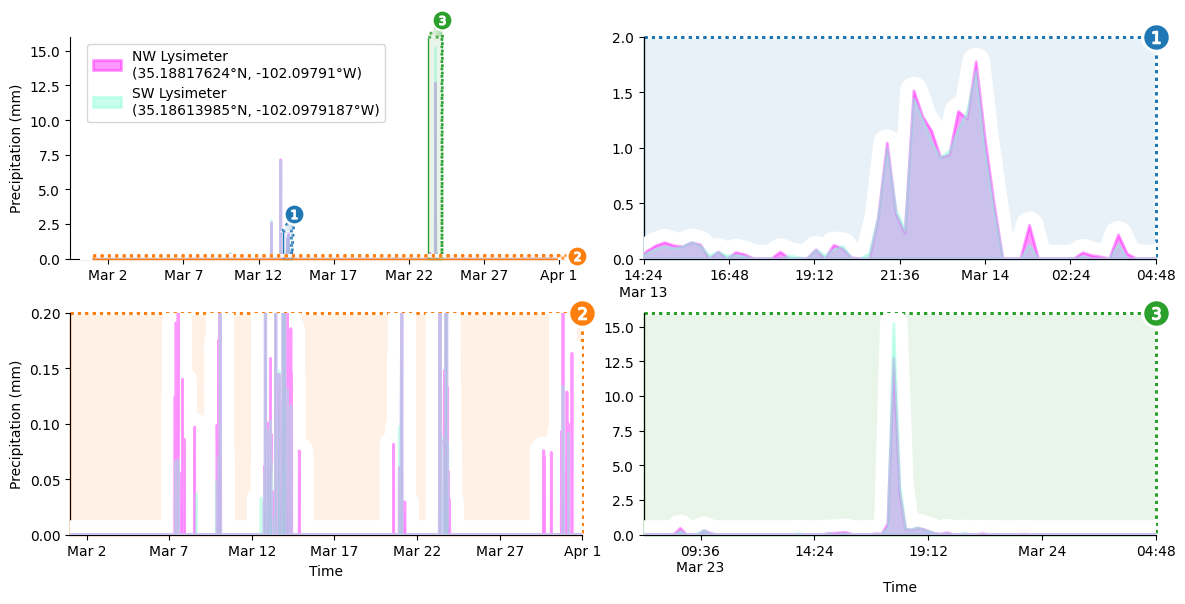

In [13]:
try:
    display(grid.figure)  # shows completed figure if notebook already ran
except NameError:
    pass

## Setup

Begin by importing necessary packages.

Notably:
- `datetime` for converting the month and day values from day-of-year
- `pandas` for data management
- `matplotlib` for plotting area charts using `stackplot`
- `outset` for managing multi-zoom grid and zoom indicators

In [2]:
from datetime import datetime, timedelta
import itertools as it
import typing

from matplotlib import pyplot as plt
from matplotlib import text as mpl_text
import numpy as np
import outset as otst
import opytional as opyt
import pandas as pd
import seaborn as sns


To install dependencies for this exercise,

```bash
python3 -m pip install \
    matplotlib `# ==3.8.2`\
    numpy `# ==1.26.2` \
    outset `# ==0.1.4` \
    opytional `# ==0.1.0` \
    pandas `# ==2.1.3` \
    seaborn `# ==0.13.0`
```

## Data Preparation

Next, fetch our data and do a little work on it: rename columns and subset data down to just the month of March.


In [3]:
df = pd.read_csv("https://osf.io/6mx3e/download")  # download data

nwls = "NW Lysimeter\n(35.18817624°N, -102.09791°W)"
swls = "SW Lysimeter\n(35.18613985°N, -102.0979187°W)"
df[nwls], df[swls] = df["NW precip in mm"], df["SW precip in mm"]

# filter down to just data from March 2019
march_df = df[np.clip(df["Decimal DOY"], 59, 90) == df["Decimal DOY"]]

march_df  # show snippet of dataframe content

,Year,Decimal DOY,NW dew/frost in mm,SW dew/frost in mm,NW precip in mm,SW precip in mm,NW irrig. in mm,SW irrig. in mm,NW ET in mm,SW ET in mm,"NW Lysimeter\n(35.18817624°N, -102.09791°W)","SW Lysimeter\n(35.18613985°N, -102.0979187°W)"
5568,2019,59.010417,0.005681,0.000000,0.0,0.0,0.0,0.0,-0.001523,-0.005245,0.0,0.0
5569,2019,59.020833,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018815,-0.005285,0.0,0.0
5570,2019,59.031250,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.009881,0.002503,0.0,0.0
5571,2019,59.041667,0.000000,0.002464,0.0,0.0,0.0,0.0,-0.006134,0.002146,0.0,0.0
5572,2019,59.052083,0.000000,0.000000,0.0,0.0,0.0,0.0,0.005352,0.000119,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8538,2019,89.947917,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.013010,-0.005682,0.0,0.0
8539,2019,89.958333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001976,-0.003616,0.0,0.0
8540,2019,89.968750,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.001029,0.002821,0.0,0.0
8541,2019,89.979167,0.000000,0.003894,0.0,0.0,0.0,0.0,0.001976,0.002940,0.0,0.0


Here's a preliminary look at the time series.

<Axes: xlabel='Decimal DOY', ylabel='NW precip in mm'>

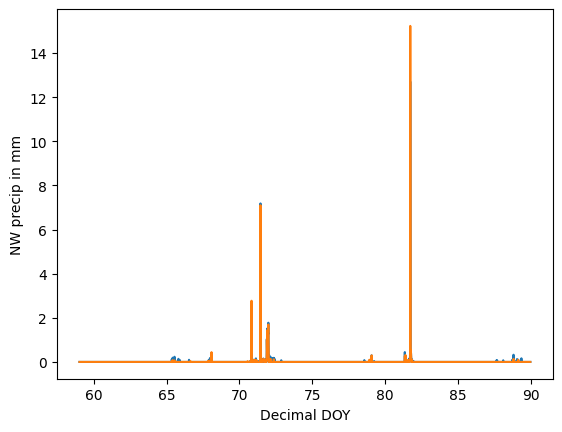

In [4]:
ax = sns.lineplot(data=march_df, x="Decimal DOY", y="NW precip in mm")
sns.lineplot(data=march_df, x="Decimal DOY", y="SW precip in mm", ax=ax)

We've certainly got some work to do to nice this up!

Our visualization will focus on showing three details that are difficult to make out in a naive visualization *1)* a little shower around day 72, *2)* the big rainstorm around day 82, and *3)* light precipitation events over the course of the entire month.
We'll create a zoom panel to show each of these components.

# Setup Axes Grid

Our first plotting step is to initialize an `outset.OutsetGrid` to manage content and layout of our planned axes grid.
This class operates analogously to seaborn's [`FacetGrid`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html), if you're familiar with that.

We'll provide a list of the main plot regions we want to magnify through the `data` kwarg.
Other kwargs provide styling and layout information, including how we want plots to be shaped and how many columns we want to have.

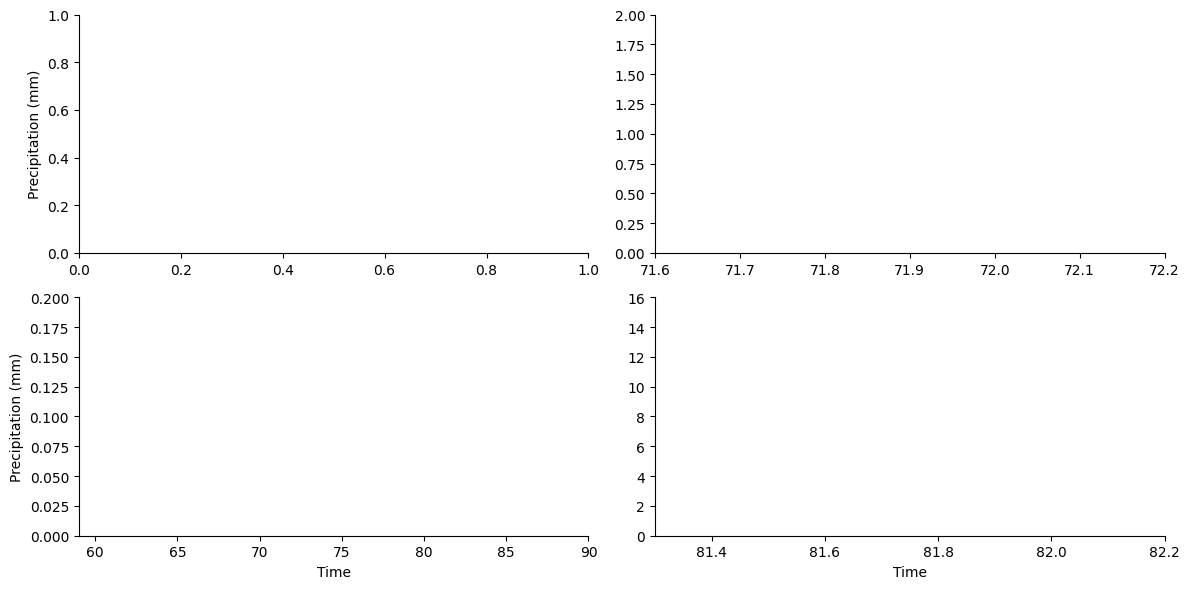

In [5]:
grid = otst.OutsetGrid(  # initialize axes grid manager
    data=[
        # (x0, y0, x1, y1) regions to outset
        (71.6, 0, 72.2, 2),  # little shower around day 72
        (59, 0, 90, 0.2),  # all light precipitation events
        (81.3, 0, 82.2, 16),  # big rainstorm around day 82
    ],
    x="Time",
    y="Precipitation (mm)",  # label axes
    aspect=2,  # make subplots wide
    col_wrap=2,  # wrap subplots into a 2x2 grid
    # styling for zoom indicator annotations, discussed later
    marqueeplot_kws={"frame_outer_pad": 0, "mark_glyph_kws": {"zorder": 11}},
    marqueeplot_source_kws={"zorder": 10, "frame_face_kws": {"zorder": 10}},
)

pass  # sponge up last return value, if any

## Set Up Plot Content

Next, we'll set up the content of our plots --- overlapped area plots showing the two rain gauges' readings.

Matplotlib's [`stackplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stackplot.html) is designed to create area plots with areas "stacked" on top of each other instead of overlapping.
To get an overlap, we'll call `stackplot` twice so that each "stack" contains only one of our variables.

We will use `OutsetGrid.broadcast` to draw the same content across all four axes in our grid.
This method take a plotter function as its first argument then calls it with subsequent arguments forwarded to it on each axis.

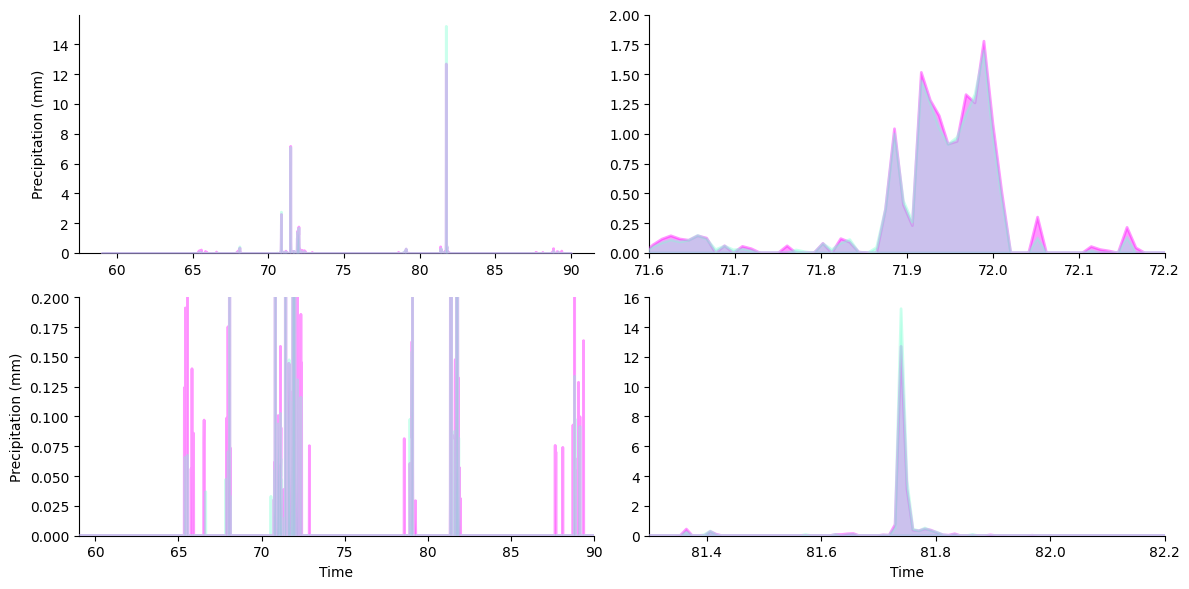

In [6]:
# draw semi-transparent filled lineplot on all axes for each lysimeter
for y, color in zip([nwls, swls], ["fuchsia", "aquamarine"]):
    grid.broadcast(
        plt.stackplot,  # plotter
        march_df["Decimal DOY"],  # all kwargs below forwarded to plotter...
        march_df[y],
        colors=[color],
        labels=[y],
        lw=2,
        edgecolor=color,
        alpha=0.4,  # set to 60% transparent (alpha 1.0 is non-transparent)
        zorder=10,
    )

pass  # sponge up last return value, if any

To pretty things up, e'll lay down a white underlay around the stackplots for better contrast against background fills.

We can do this by drawing another stackplot that tracks the maximum reading between our rain gauges at each point in time.
Specifying a lower `zorder` for this plot causes it to be drawn below the other stackplots.

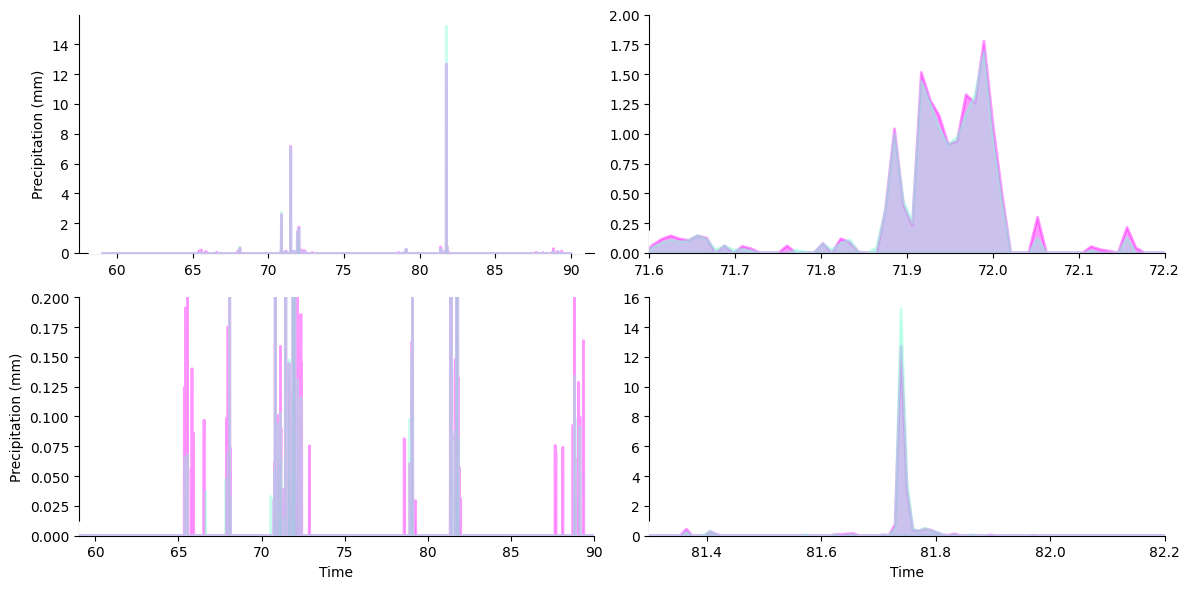

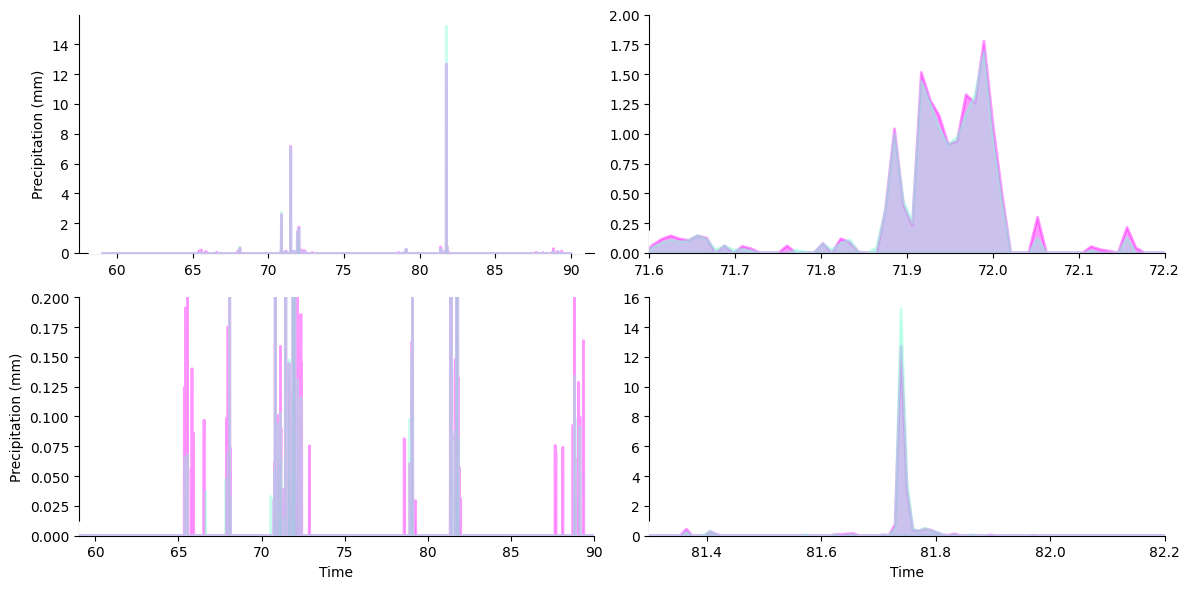

In [7]:
ys = np.maximum(march_df["SW precip in mm"], march_df["NW precip in mm"])
grid.broadcast(
    plt.stackplot,  # plotter
    march_df["Decimal DOY"],  # all kwargs below forwarded to plotter...
    ys,
    colors=["white"],
    lw=20,  # thick line width causes protrusion of white border
    edgecolor="white",
    zorder=9,  # note lower zorder positions underlay below stackplots
)

display(grid.figure)  # show current progress

pass  # sponge up last return value, if any

# Add Zoom Indicators

Now it's time to add zoom indicator boxes, a.k.a. `outset` "marquees," to show how the scales of our auxiliary plots relate to the scale of the main plot.
Note that we pass a kwarg to allow aspect ratios to vary between the main plot and outset plots.
That way, zoom areas can be expanded along their smaller dimension to take full advantage of available space.

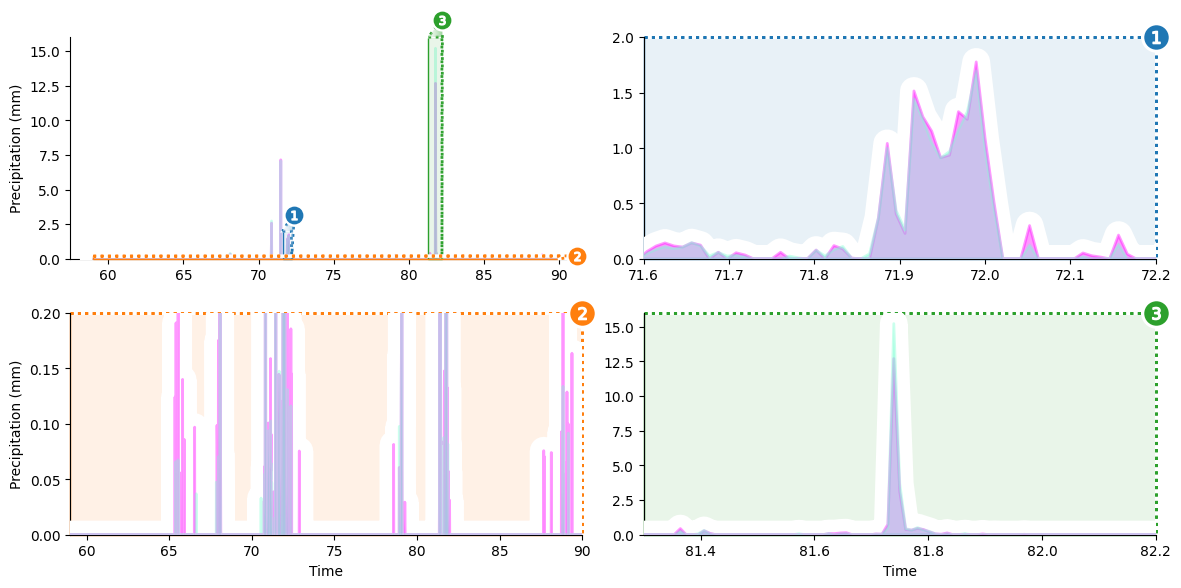

In [8]:
# draw "marquee' zoom indicators showing correspondences between main plot
# and outset plots
grid.marqueeplot(equalize_aspect=False)  # allow axes aspect ratios to vary

display(grid.figure)  # show current progress

pass  # sponge up last return value, if any

## Replace Numeric Tick Labels with Human-readable Timestamps

We're almost there!
But the x-axis tick labels are still numeric "day of year" values, which is not very intuitive.
I don't know off the top of my head what day 42 of the year corresponds to, do you?

Let's fix that.
To replace the existing tick labels with timestamps, we'll define a function that takes a numeric day of the year and returns a human-readable timestamp.
We'll always include the time of day, but we'll only include the date on between-day transitions.
We'll also need helper function to convert numeric day of the year to a Python datetime object.

In [9]:
# helper function
def to_dt(day_of_year: float, year: int = 2019) -> datetime:
    """Convert decimal day of the year to a datetime object."""
    return datetime(year=year, month=1, day=1) + timedelta(days=day_of_year)


def format_tick_value(
    prev_value: typing.Optional[mpl_text.Text],
    value: mpl_text.Text,
) -> str:
    """Create human-readable timestamp to replace a numeric axes tick.

    Adjust date string content based on whether previous tick is a different
    calendar day than the current tick.
    """
    decimal_doy = float(value.get_text())
    prev_decimal_doy = opyt.apply_if(prev_value, lambda x: float(x.get_text()))

    # if the previous tick is the same day as this tick...
    # (note: first tick has no previous tick, so prev_decimal_day is None)
    if int(decimal_doy) == opyt.apply_if(prev_decimal_doy, int):
        # ... then just label with time of day
        return to_dt(decimal_doy).strftime("%H:%M")
    # otherwise, if prev tick is different day AND this tick near midnight...
    elif decimal_doy % 1.0 < 1 / 24:
        # ... then just label date and not time of day
        return to_dt(decimal_doy).strftime("%b %-d")
    # otherwise, prev tick is different day and this tick NOT near midnight...
    else:
        # ... label with time of day AND date
        return to_dt(decimal_doy).strftime("%H:%M\n%b %-d")

With this out of the way, we can loop over the axes in our grid and perform the label replacement.

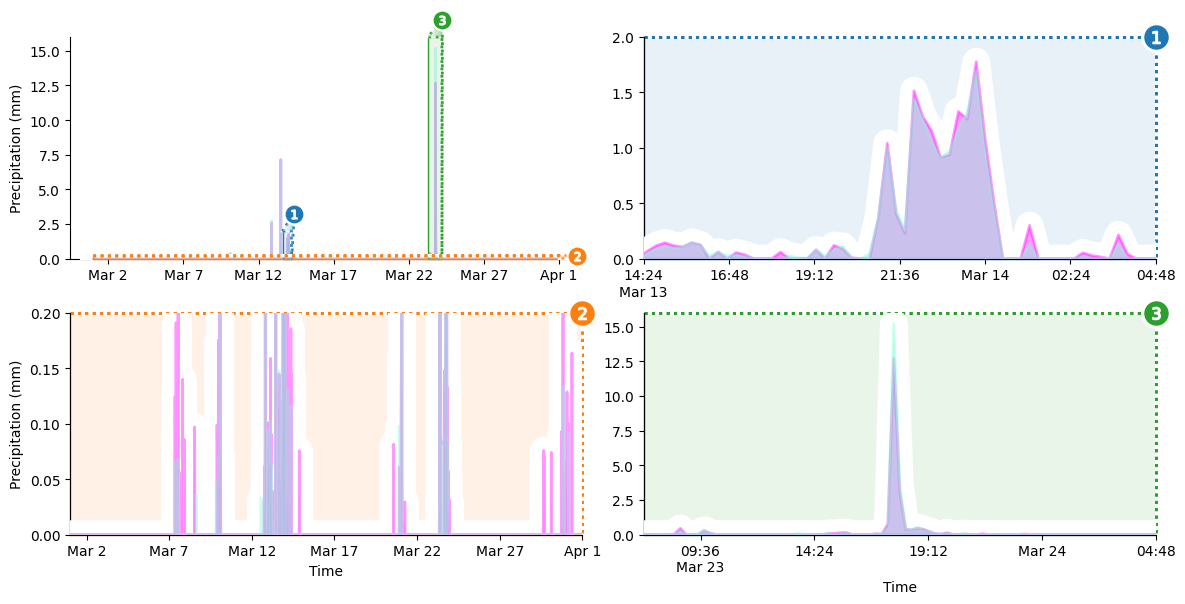

In [10]:
for ax in grid.axes.flat:  # iterate over all axes in grid
    # first, filter x ticks to keep only ticks that are within axes limits
    ax.set_xticks(
        [val for val in ax.get_xticks() if np.clip(val, *ax.get_xlim()) == val]
    )
    # second, map format_tick_value over tick positions to make tick timestamps
    new_tick_labels = it.starmap(
        format_tick_value,  # mapped function
        # ... taking sequential tick pairs as arguments,
        # front-padded with None (first tick has no preceding tick)
        it.pairwise((None, *ax.get_xticklabels())),
    )
    # third, replace existing tick labels with new timestamp tick labels
    ax.set_xticklabels([*new_tick_labels])  # make list b/c mpl rejects iters

display(grid.figure)  # show current progress

pass  # sponge up last return value, if any

## Final Details

The last order of business is to add a legend to the upper left corner of the main plot.

In [11]:
grid.source_axes.legend(  # add legend to primary axes
    loc="upper left",
    bbox_to_anchor=(0.02, 1.0),  # legend positioning
    frameon=True,  # styling: turn on legend frame
)

pass  # sponge up last return value, if any

# Et Voilà!

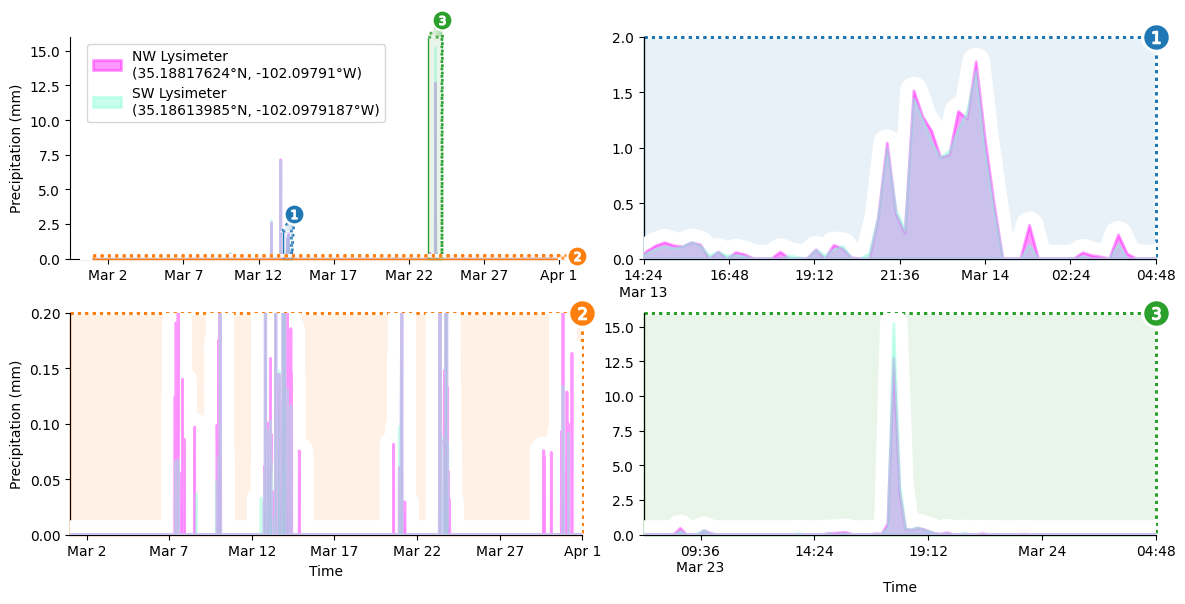

In [12]:
display(grid.figure)  # show completed figure!

pass  # sponge up last return value, if any

## Further Information

You can read more about stackplot in the matplotlib documentation [here](https://matplotlib.org/stable/gallery/lines_bars_and_markers/stackplot_demo.html).

Refer to the `outset` [*quickstart guide*](https://mmore500.com/outset/quickstart.html) and [*gallery*](https://mmore500.com/outset/gallery.html) for more information about that library.
In addition to explicit zoom area selection as above, the outset library also provides a seaborn-like data-oriented API to infer zoom inserts containing categorical subsets of a dataframe.
There are tools to reposition "outset" auxiliary axes as insets over the main axes, too.

## Authorship

This tutorial is contributed by me, [Matthew Andres Moreno](https://mmore500.com/).
I currently serve as a postdoctoral scholar at the University of Michigan, where my work is supported by the Eric and Wendy Schmidt AI in Science Postdoctoral Fellowship, a Schmidt Futures program.
My appointment is split between the university's Ecology and Evolutionary Biology Department, the Center for the Study of Complexity, and the Michigan Institute for Data Science.

Find me on Twitter as [@MorenoMatthewA](https://twitter.com/morenomatthewa) and on GitHub as [@mmore500](https://github.com/mmore500/).

*disclosure:* I am the author of the `outset` library.

## Citations

> Evett, Steven R.; Marek, Gary W.; Copeland, Karen S.; Howell, Terry A. Sr.; Colaizzi, Paul D.; Brauer, David K.; Ruthardt, Brice B. (2023). Evapotranspiration, Irrigation, Dew/frost - Water Balance Data for The Bushland, Texas Soybean Datasets. Ag Data Commons. https://doi.org/10.15482/USDA.ADC/1528713. Accessed 2023-12-26.

> J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007. https://doi.org/10.1109/MCSE.2007.55

> Marek, G. W., Evett, S. R., Colaizzi, P. D., & Brauer, D. K. (2021). Preliminary crop coefficients for late planted short-season soybean: Texas High Plains. Agrosystems, Geosciences & Environment, 4(2). https://doi.org/10.1002/agg2.20177

> Matthew Andres Moreno. (2023). mmore500/outset. Zenodo. https://doi.org/10.5281/zenodo.10426106

> Data structures for statistical computing in python, McKinney, Proceedings of the 9th Python in Science Conference, Volume 445, 2010. https://doi.org/ 10.25080/Majora-92bf1922-00a

> Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.